In [1]:
import yfinance as yf
import numpy as np

In [2]:
df = yf.download("DJIA", start="2000-01-01")

[*********************100%***********************]  1 of 1 completed


In [3]:
df

Open          High           Low         Close  \
Date                                                                 
1999-12-31  11453.480469  11598.259766  11368.049805  11497.120117   
2000-01-03  11501.849609  11641.070312  11180.980469  11357.509766   
2000-01-04  11349.750000  11358.440430  10907.030273  10997.929688   
2000-01-05  10989.370117  11337.650391  10862.660156  11122.650391   
2000-01-06  11113.370117  11447.790039  10963.179688  11253.259766   
...                  ...           ...           ...           ...   
2020-09-08  27925.230469  27925.230469  27464.900391  27500.890625   
2020-09-09  27711.710938  28206.210938  27704.539062  27940.470703   
2020-09-10  28022.509766  28174.779297  27447.080078  27534.580078   
2020-09-11  27613.859375  27828.820312  27448.150391  27665.640625   
2020-09-14  27718.740234  28086.060547  27718.740234  27993.330078   

               Adj Close      Volume  
Date                                  
1999-12-31  11497.120117   374050000  
2000-01-03  11357.509766   931800000  
2000-01-04  10997.929688  1009000000  
2000-01-05  11122.650391  1085500000  
2000-01-06  11253.259766  1092300000  
...                  ...         ...  
2020-09-08  27500.890625  4665600000  
2020-09-09  27940.470703  3920830000  
2020-09-10  27534.580078  4192250000  
2020-09-11  27665.640625  3704450000  
2020-09-14  27993.330078  3832130000  

[5209 rows x 6 columns]

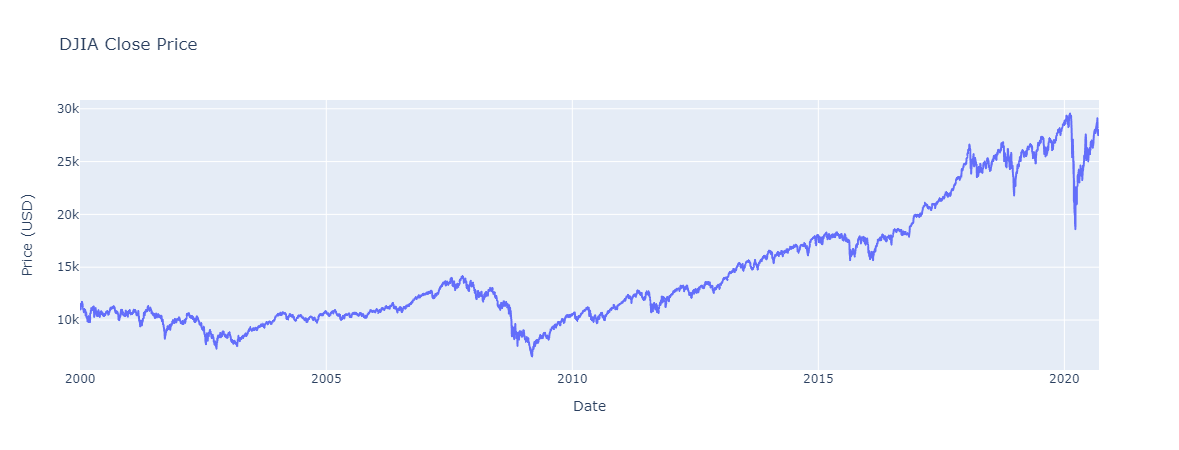

In [4]:
import plotly.graph_objs as go
import plotly.express as px

fig = px.line(df['Close'])
fig.layout = go.Layout({"title": "DJIA Close Price",
                           "yaxis": {"title":"Price (USD)"},
                           "xaxis": {"title":"Date"},
                           "showlegend": False})
fig.show()

### Log Diff

In [5]:
# use log base 10 for percentage change
df['LogDiff'] = np.concatenate(([0], np.diff(np.log(df['Close'].values), n=1)))

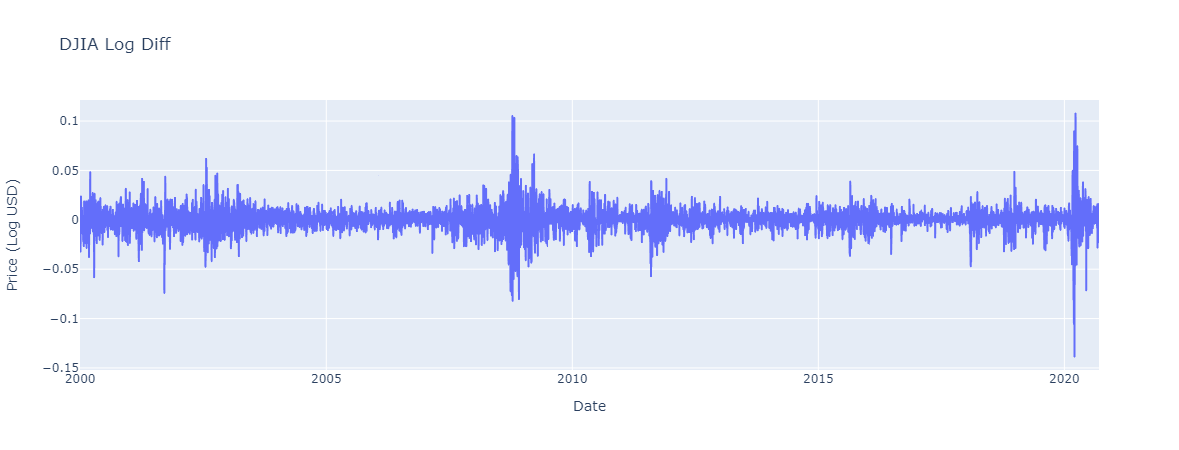

In [6]:
fig = px.line(df['LogDiff'])
fig.layout = go.Layout({"title": "DJIA Log Diff",
                           "yaxis": {"title":"Price (Log USD)"},
                           "xaxis": {"title":"Date"},
                           "showlegend": False})
fig.show()

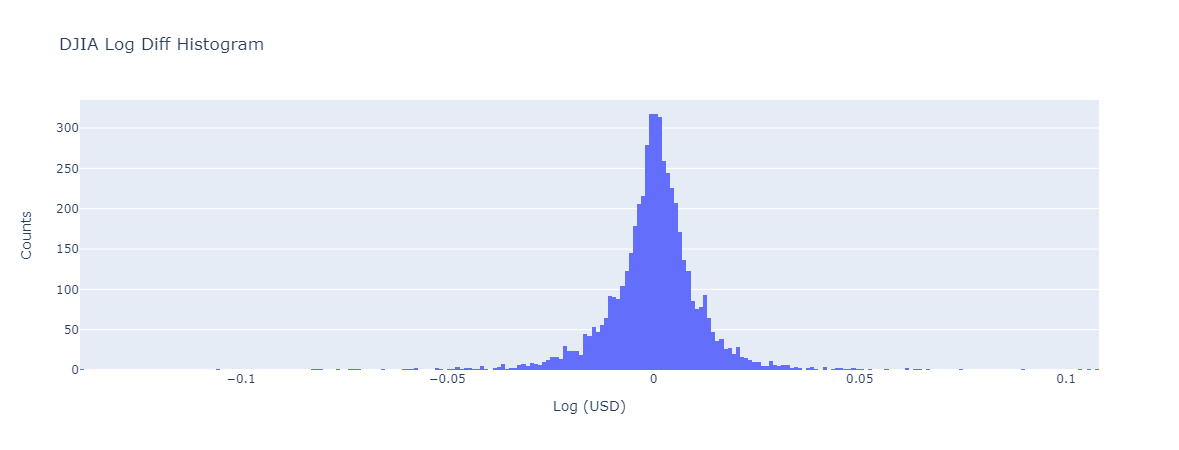

In [7]:
fig = px.histogram(df['LogDiff'])
fig.layout = go.Layout({"title": "DJIA Log Diff Histogram",
                           "yaxis": {"title":"Counts"},
                           "xaxis": {"title":"Log (USD)"},
                           "showlegend": False})
fig.show()

In [8]:
import tensorflow as tf
import numpy as np

class TCNDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, train_timesteps=100, pred_timesteps=1, batch_size=128, n_channels=1, shuffle=False):
        self.data = data
        self.train_timesteps = train_timesteps
        self.pred_timesteps = pred_timesteps
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.signals = (len(self.data)-(self.train_timesteps+self.pred_timesteps))
        self.indexes = np.arange(self.signals-1)
        if shuffle:
            np.random.shuffle(self.indexes)
        
    def __len__(self):
        return int(np.floor( self.signals / self.batch_size )-1)
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        start_indicies = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        #print(start_indicies)
        
        # Generate data
        X, y = self.__data_generation(start_indicies)

        return X, y
    
    def on_epoch_end(self):
        return
    
    def __data_generation(self, start_indicies):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.train_timesteps, self.n_channels))
        y = np.empty((self.batch_size, self.pred_timesteps))
        
        # Generate sequence data
        for i, index in enumerate(start_indicies):
            
            #print(i, index, index+self.train_timesteps, index+self.train_timesteps+self.pred_timesteps, len(self.data))
            # Store sample
            X[i,:,0] = self.data[index:index+self.train_timesteps]

            # This is for sequence prediction
            if self.pred_timesteps == 1:
                y[i, 0] = self.data[index+self.train_timesteps]
            else:
                y[i, :] = self.data[index+self.train_timesteps:index+self.train_timesteps+self.pred_timesteps]
            
            # This is for fluctuation prediction
            # d_ = (self.data[index+self.train_timesteps-1] - self.data[index+self.train_timesteps-2])/(self.data[index+self.train_timesteps-2])
            # d = (self.data[index+self.train_timesteps] - self.data[index+self.train_timesteps-1])/(self.data[index+self.train_timesteps-1])
            # y[i,:] = d - d_
                                                                                                             
        return X, y

In [9]:
gen = TCNDataGenerator(data = df['LogDiff'].values,
                              train_timesteps = 432,
                              pred_timesteps = 1,
                              batch_size = 256)

In [10]:
len(gen)

17

In [11]:
x, y = gen[len(gen)]

In [12]:
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(256, 432, 1) (256, 1)
float64 float64


In [13]:
import matplotlib.pyplot as plt
x_error_count = 0
y_error_count = 0
for g_i in range(len(gen)+1):
    x, y = gen[g_i]
    for i in range(x.shape[0]):
        if np.mean(x[i,:,0]) < 5000:
            x_error_count += 1
        if (y[i,0] < 5000):
            y_error_count += 1
print(x_error_count, y_error_count)

4608 4608


In [14]:
del(gen)
del(x_error_count)
del(y_error_count)

### Metric for Fluctuation

First, get time intervals of abrupt changes by figuring out the difference of stock fluctuation degree D(fluctuation) between two adjacent stock trading days

\begin{equation*}
D_{fluctutation}
=
\frac{x_t-x_{t-1}}{x_{t-1}}
\end{equation*}

where x at time t denotes the stock price value on the stock trading day t. Then the difference of fluctuation degree C is defined by:

\begin{equation*}
C_{i}
=
D_{fluctutation_{i}} - D_{fluctutation_{i-1}}
\end{equation*}

If $C_{i}$ exceeds a certain threshold, it can be considered that the stock price abruptly changes at the ith day.

In [15]:
from tensorflow.keras import Input, optimizers, Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import backend as K
from tcn import TCN

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_tcn(max_len, num_feat, output_len, lr=0.002):
    # Receptive field = nb_stacks_of_residuals_blocks * kernel_size * last_dilation.
    # --> 24 * 8 * 1 = 216
    input_layer = Input(shape=(max_len, num_feat))
    x = TCN(nb_filters=24, 
            kernel_size=8, 
            nb_stacks=1, 
            dilations=[2 ** i for i in range(8)],
            padding='causal',
            use_skip_connections=True, 
            dropout_rate=0.0, 
            return_sequences=False,
            activation='relu', 
            kernel_initializer='he_normal', 
            use_batch_norm=False, 
            use_layer_norm=False,
            name='tcn')(input_layer)
    opt = optimizers.Adam(lr=lr, clipnorm=1.)
    # Regression
    # hidden layer -> output layer
    # x = Dense(units=20, activation=tf.nn.relu)(x)
    x = Dense(output_len, activation=None)(x)
    output_layer = x
    model = Model(input_layer, output_layer)
    model.compile(opt, loss='mean_squared_error')
    return model

In [16]:
import matplotlib.pyplot as plt

def GetSpacedElements(array, numElems = 4):
    out = array[np.round(np.linspace(0, len(array)-1, numElems)).astype(int)]
    return out

def visualise_test(data, real_data, tst_idx, model, input_length, output_length):
    start_indicies = GetSpacedElements(tst_idx[0:len(tst_idx)-(input_length+output_length)], 4)
    print(start_indicies)
    for st_index in start_indicies:
        print(st_index)
        X = data[st_index:st_index+input_length]
        real_X = real_data[st_index:st_index+input_length]
        print(X.shape)
        y_pred = model(np.expand_dims(X, axis=0))
        y_true = data[st_index+input_length]
        plt.figure(figsize=(10,7))
        plt.subplot(211)
        plt.plot(np.arange(len(X)), X)
        plt.subplot(212)
        plt.plot(np.arange(len(real_X)), real_X)
        plt.title('Predicted: {}, Actual: {}'.format(y_pred, y_true))
        plt.show()

In [17]:
def test_error_count(gen):
    x_error_count = 0
    y_error_count = 0
    for g_i in range(len(gen)+1):
        x, y = gen[g_i]
        for i in range(x.shape[0]):
            if np.mean(x[i,:,0]) < 5000:
                x_error_count += 1
            if y[i,0] < 5000:
                y_error_count += 1
    print(x_error_count, y_error_count)

Fold: 1
Fitting...
Epoch 1/100
2/2 [==============================] - 0s 51ms/step - loss: 0.1346
Epoch 2/100
2/2 [==============================] - 0s 79ms/step - loss: 0.0080
Epoch 3/100
2/2 [==============================] - 0s 81ms/step - loss: 0.0014
Epoch 4/100
2/2 [==============================] - 0s 80ms/step - loss: 0.0024
Epoch 5/100
2/2 [==============================] - 0s 80ms/step - loss: 0.0019
Epoch 6/100
2/2 [==============================] - 0s 81ms/step - loss: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 81ms/step - loss: 4.1245e-04
Epoch 8/100
2/2 [==============================] - 0s 82ms/step - loss: 3.9036e-04
Epoch 9/100
2/2 [==============================] - 0s 82ms/step - loss: 5.5844e-04
Epoch 10/100
2/2 [==============================] - 0s 80ms/step - loss: 5.3431e-04
Epoch 11/100
2/2 [==============================] - 0s 81ms/step - loss: 3.8460e-04
Epoch 12/100
2/2 [==============================] - 0s 80ms/step - loss: 2.7510e-04
Epoch 

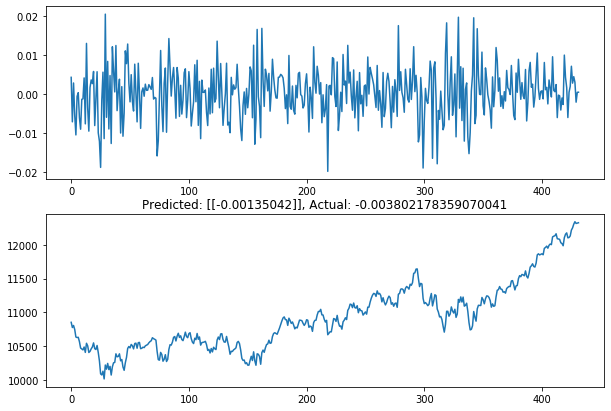

1592
(432,)


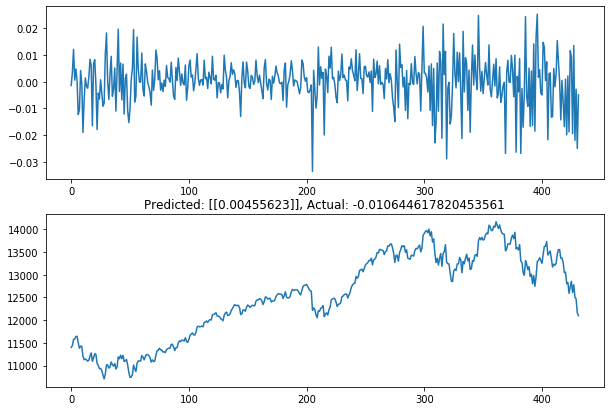

1882
(432,)


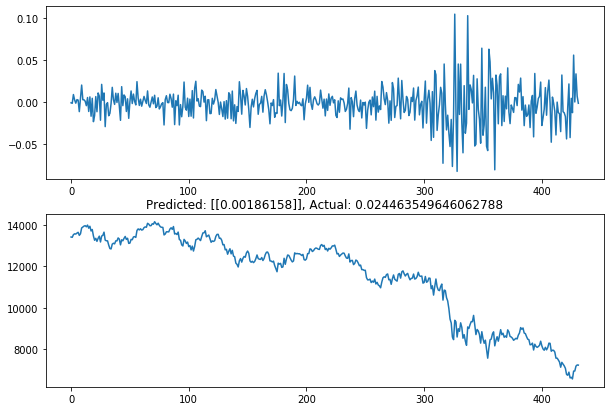

2171
(432,)


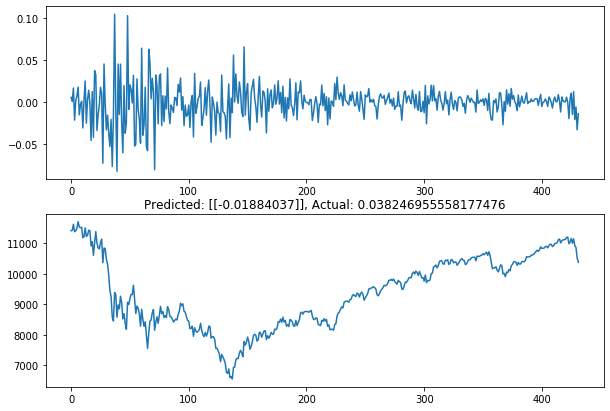

Fold: 2
Fitting...
Epoch 1/100
7/7 [==============================] - 1s 99ms/step - loss: 0.0985
Epoch 2/100
7/7 [==============================] - 1s 94ms/step - loss: 0.0021
Epoch 3/100
7/7 [==============================] - 1s 93ms/step - loss: 3.6838e-04
Epoch 4/100
7/7 [==============================] - 1s 93ms/step - loss: 2.9329e-04
Epoch 5/100
7/7 [==============================] - 1s 93ms/step - loss: 2.1910e-04
Epoch 6/100
7/7 [==============================] - 1s 93ms/step - loss: 1.9487e-04
Epoch 7/100
7/7 [==============================] - 1s 94ms/step - loss: 1.8644e-04
Epoch 8/100
7/7 [==============================] - 1s 94ms/step - loss: 1.7816e-04
Epoch 9/100
7/7 [==============================] - 1s 93ms/step - loss: 1.7040e-04
Epoch 10/100
7/7 [==============================] - 1s 93ms/step - loss: 1.6617e-04
Epoch 11/100
7/7 [==============================] - 1s 92ms/step - loss: 1.6299e-04
Epoch 12/100
7/7 [==============================] - 1s 96ms/step - loss: 1

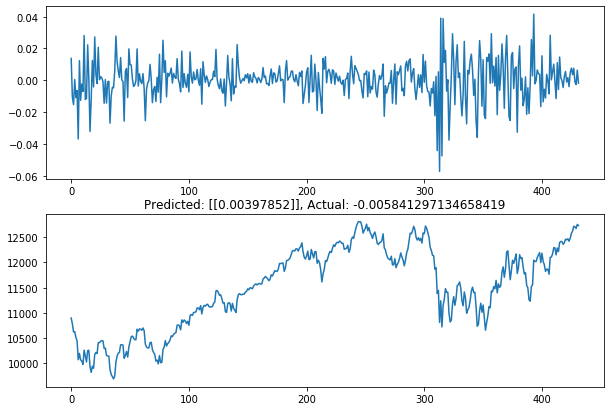

2894
(432,)


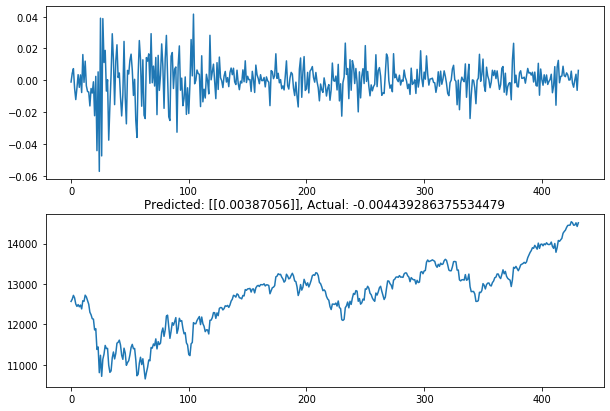

3184
(432,)


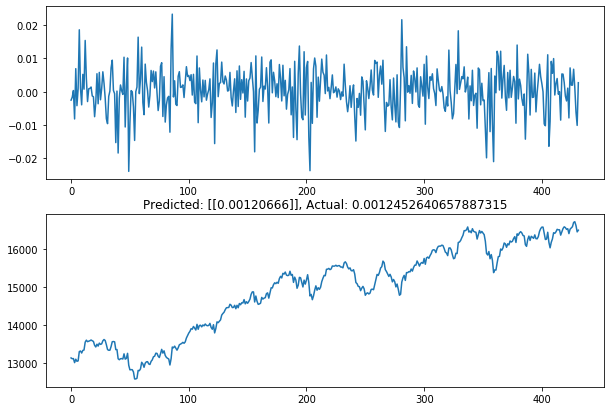

3473
(432,)


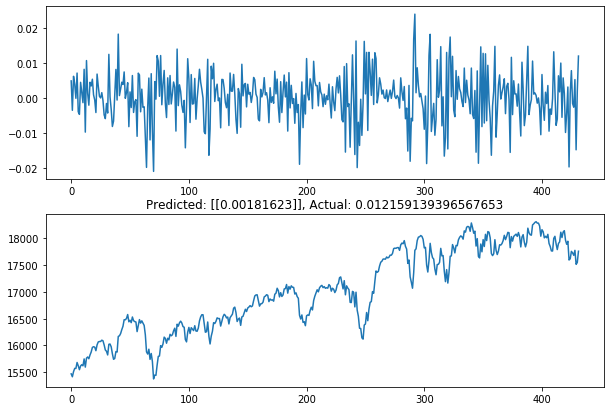

Fold: 3
Fitting...
Epoch 1/100
12/12 [==============================] - 1s 98ms/step - loss: 0.0708
Epoch 2/100
12/12 [==============================] - 1s 95ms/step - loss: 0.0014
Epoch 3/100
12/12 [==============================] - 1s 95ms/step - loss: 4.7886e-04
Epoch 4/100
12/12 [==============================] - 1s 96ms/step - loss: 2.8910e-04
Epoch 5/100
12/12 [==============================] - 1s 95ms/step - loss: 2.5528e-04
Epoch 6/100
12/12 [==============================] - 1s 96ms/step - loss: 2.3351e-04
Epoch 7/100
12/12 [==============================] - 1s 95ms/step - loss: 2.1746e-04
Epoch 8/100
12/12 [==============================] - 1s 95ms/step - loss: 2.0826e-04
Epoch 9/100
12/12 [==============================] - 1s 96ms/step - loss: 2.0105e-04
Epoch 10/100
12/12 [==============================] - 1s 100ms/step - loss: 1.8967e-04
Epoch 11/100
12/12 [==============================] - 1s 100ms/step - loss: 1.8624e-04
Epoch 12/100
12/12 [==============================

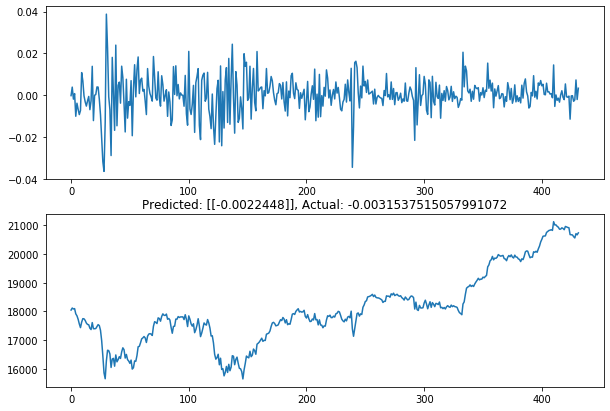

4196
(432,)


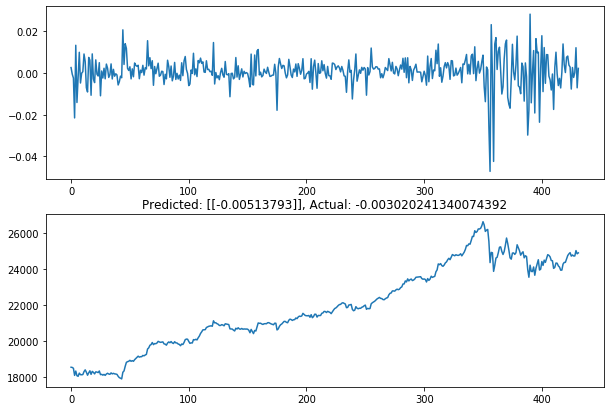

4486
(432,)


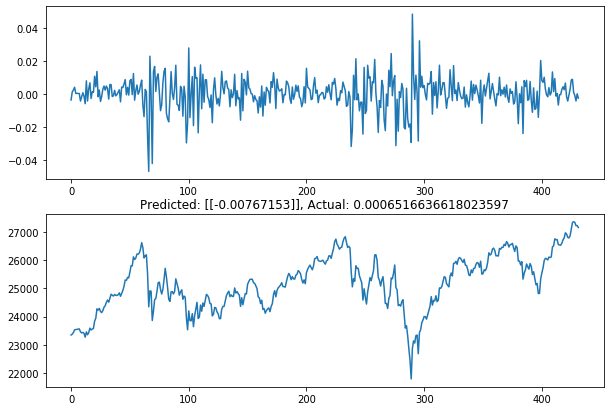

4775
(432,)


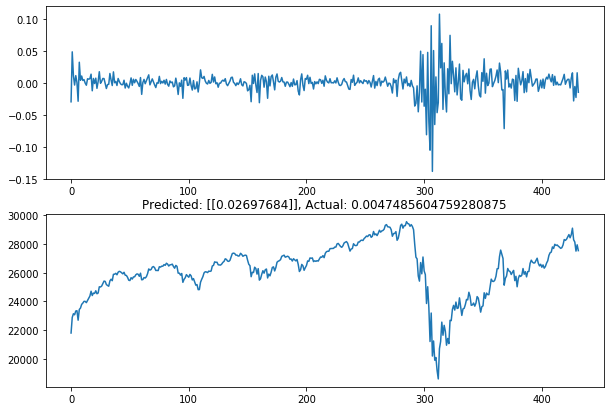

In [18]:
from sklearn.model_selection import TimeSeriesSplit

epochs = 100
input_length = 432
output_length = 1

tscv = TimeSeriesSplit(max_train_size=None, n_splits=3)
data = df['LogDiff'].values
#data = df['Close'].values 
fold = 1

for trn_idx, tst_idx in tscv.split(data):
    
        print("Fold: {}".format(fold))
        fold = fold+1
        
        gen = TCNDataGenerator(data = data[trn_idx],
                              train_timesteps = input_length,
                              pred_timesteps = output_length,
                              batch_size = 256)
        model = build_tcn(num_feat=1, max_len=input_length, output_len=output_length)
        
        print("Fitting...")
        # Verbosity set to 1 because it doesn't behave very well in Jupyter Notebook
        model.fit(gen, epochs=epochs, verbose=1)
        
        # Test Model
        gen = TCNDataGenerator(data = data[tst_idx],
                      train_timesteps = input_length,
                      pred_timesteps = output_length,
                      batch_size = 256)
        
        print("Evalutating...")
        model.evaluate(gen, verbose=1)
        
        print("Visualising...")
        visualise_test(data, df['Close'].values, tst_idx, model, input_length, output_length)